In [6]:
import os
os.environ['http_proxy'] = "http://127.0.0.1:10811"
os.environ['https_proxy'] = "http://127.0.0.1:10811"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

/root/anaconda3/envs/trl/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


BLEU Score for answer_0:  5.317223221528927e-60
BLEU Score for answer_1:  5.612748513330374e-74
ROUGE Scores for answer_0:  {'rouge-1': {'r': 0.3054410711918335, 'p': 0.2351712280424612, 'f': 0.22753598628551738}, 'rouge-2': {'r': 0.11270829906859352, 'p': 0.06547240413193933, 'f': 0.07015474260934736}, 'rouge-l': {'r': 0.27312731326299067, 'p': 0.21127602698839137, 'f': 0.20350292041001214}}
ROUGE Scores for answer_1:  {'rouge-1': {'r': 0.4513839288092702, 'p': 0.29190331749817844, 'f': 0.3043494541095318}, 'rouge-2': {'r': 0.23407676543648834, 'p': 0.1143794874670074, 'f': 0.12298855754912362}, 'rouge-l': {'r': 0.4218279408312398, 'p': 0.26745498264242573, 'f': 0.27988101675528093}}


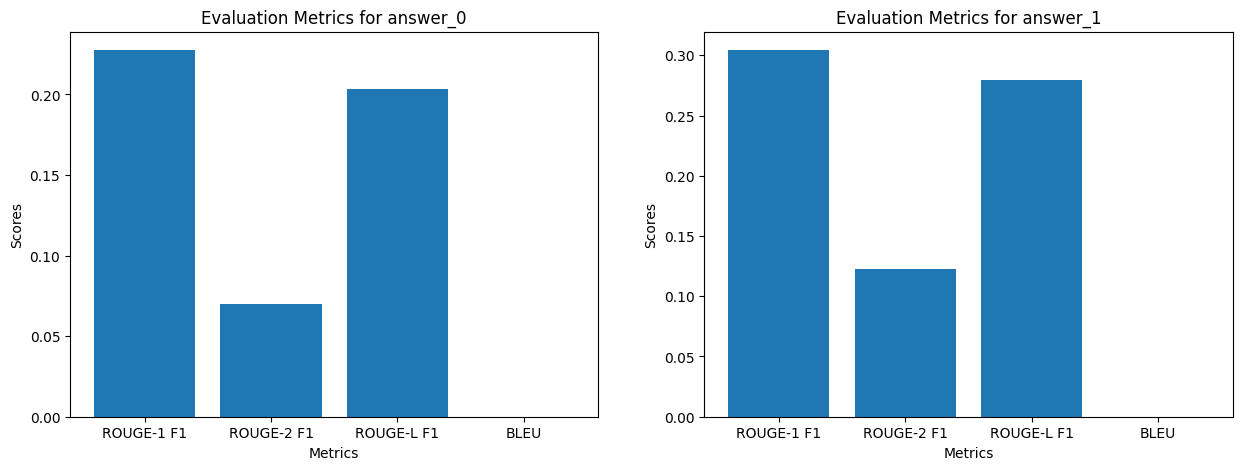

In [9]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import pandas as pd
from collections import Counter
from nltk.util import ngrams
import math
from rouge import Rouge
import matplotlib.pyplot as plt

# Load the dataset from the uploaded file
file_path = 'cleaned_first_100rows_with_reference.csv'  # Corrected file path
df = pd.read_csv(file_path)

# Extract prompts, answer_0, answer_1, and reference_answer
prompts = df['question'].tolist()
answers_0 = df['answer_0'].tolist()
answers_1 = df['answer_1'].tolist()
references = df['reference_answer'].tolist()  # Assuming 'reference_answer' column exists

# Load the trained model and tokenizer
model_id = "output"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    use_cache=False,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.truncation_side = 'left'

# Generate the output for BLEU and ROUGE evaluation
def generate_outputs(prompts):
    outputs = []
    with torch.no_grad():
        for prompt in prompts:
            inputs = tokenizer(prompt, return_tensors="pt")
            output = model.generate(**inputs, max_length=100)
            outputs.append(tokenizer.decode(output[0], skip_special_tokens=True))
    return outputs

# Evaluate BLEU Score
def modified_precision(references, candidate, n):
    counts = Counter(ngrams(candidate, n))
    if not counts:
        return 0, 1
    
    max_counts = {}
    for reference in references:
        reference_counts = Counter(ngrams(reference, n))
        for ngram in counts:
            if ngram in max_counts:
                max_counts[ngram] = max(max_counts[ngram], reference_counts[ngram])
            else:
                max_counts[ngram] = reference_counts[ngram]
    
    clipped_counts = {ngram: min(count, max_counts[ngram]) for ngram, count in counts.items()}
    return sum(clipped_counts.values()), sum(counts.values())

def brevity_penalty(reference, candidate):
    ref_length = len(reference)
    cand_length = len(candidate)
    if cand_length > ref_length:
        return 1
    elif cand_length == 0:
        return 0
    else:
        return math.exp(1 - ref_length / cand_length)

def safe_log(num, denom):
    if denom == 0 or num == 0:
        return 0
    return math.log(num / denom)

def bleu_score(references, candidates, weights=[0.25, 0.25, 0.25, 0.25]):
    p_ns = []
    for i, candidate in enumerate(candidates):
        ref = references[i]
        p_n = [modified_precision([ref], candidate, n) for n in range(1, len(weights) + 1)]
        p_ns.append(p_n)
    
    s = (w * safe_log(p[0], p[1]) for p_n, w in zip(zip(*p_ns), weights) for p in p_n)
    bp = brevity_penalty(ref, candidate)
    return bp * math.exp(sum(s))

# Prepare references and candidates for BLEU evaluation
references_split = [ref.split() for ref in references]
answers_0_split = [answer.split() for answer in answers_0]
answers_1_split = [answer.split() for answer in answers_1]

bleu_0 = bleu_score(references_split, answers_0_split)
bleu_1 = bleu_score(references_split, answers_1_split)

print("BLEU Score for answer_0: ", bleu_0)
print("BLEU Score for answer_1: ", bleu_1)

# Evaluate ROUGE Score
# Initialize ROUGE evaluator
rouge = Rouge()

# Compute ROUGE scores
rouge_scores_0 = rouge.get_scores(answers_0, references, avg=True)
rouge_scores_1 = rouge.get_scores(answers_1, references, avg=True)

# Print ROUGE scores
print("ROUGE Scores for answer_0: ", rouge_scores_0)
print("ROUGE Scores for answer_1: ", rouge_scores_1)

# Plot evaluation metrics
metrics = ["ROUGE-1 F1", "ROUGE-2 F1", "ROUGE-L F1", "BLEU"]
values_0 = [rouge_scores_0['rouge-1']['f'], rouge_scores_0['rouge-2']['f'], rouge_scores_0['rouge-l']['f'], bleu_0]
values_1 = [rouge_scores_1['rouge-1']['f'], rouge_scores_1['rouge-2']['f'], rouge_scores_1['rouge-l']['f'], bleu_1]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].bar(metrics, values_0)
axs[0].set_xlabel("Metrics")
axs[0].set_ylabel("Scores")
axs[0].set_title("Evaluation Metrics for answer_0")

axs[1].bar(metrics, values_1)
axs[1].set_xlabel("Metrics")
axs[1].set_ylabel("Scores")
axs[1].set_title("Evaluation Metrics for answer_1")

plt.show()
